# TODO
* load full Model and identify significant voxels
* within each combination, calculate overlap of features and calculate unique variance

In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import scipy.stats
from statsmodels.stats.multitest import multipletests
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from neuromaps.datasets import fetch_fsaverage, fetch_fslr
from surfplot import Plot
from matplotlib import colors
import glob



In [2]:
def write_gifti_v2(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    # nib.gifti.write(gii, output_fn)
    gii.to_filename(output_fn)

In [13]:
def fsaverage_to_fslr_and_plot(Lfname, Rfname, key, cmap='inferno', min=0, max=.05):#,min=-40, max=40):
    from neuromaps.datasets import fetch_fslr
    from neuromaps.transforms import fsaverage_to_fslr
    giiL = nib.load(Lfname)
    giiR = nib.load(Rfname)
    L_fslr = fsaverage_to_fslr(giiL, target_density='32k', hemi='L', method='linear')
    R_fslr = fsaverage_to_fslr(giiR, target_density='32k', hemi='R', method='linear')
    
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    # color_range = (min,max)
    color_range = (min,max)
    p = Plot(surf_lh=lh_fslr, 
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': L_fslr[0], 
                'right': R_fslr[0]}, 
                cmap=cmap, cbar=True,
                color_range=color_range,
                cbar_label=key
                ) # YlOrRd_r
    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    # fig.show()
    return(fig)

def fisher_mean(correlation, axis=None):
    return np.tanh(np.nanmean(np.arctanh(correlation), axis=axis))

In [10]:
import numpy as np
import nibabel as nib
from os.path import join



def plot_category(giiLfname, giiRfname):
    from neuromaps.datasets import fetch_fslr
    from neuromaps.transforms import fsaverage_to_fslr
    from surfplot import Plot
    from matplotlib.colors import ListedColormap
    # NOTE 1: Define the palette (shared across left and right hemispheres)
    palette = {
        '1': '#941100', # red
        '2': '#008F51', # green
        '3': '#011891', # blue
        '4': '#808285', # gray
        '5': '#FFCC00', #yellow
        '6': '#ff3399', #pink
        '7': '#D4746D', #red + gray
        '8': '#02CDFF', # cyan
        '9':'#66C9A3', # green + gray
        '10': '#6573C1',# blue + gray
        '11': '#ffffff',# white
        '12': '#BFA640',# yello gray
        '13': '#BF598C',# pink + gray
        '14': '#41A6C0',# cyan + gray
        '15': '#808285',# white
    }
    # NOTE 2: Load the fsLR surfaces for plotting
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']

    # NOTE 3: Load the GIFTI files and convert to fsLR
    # giiL = nib.load(join('/Users/h/Desktop', "TST_argmax.lh.gii"))
    # giiR = nib.load(join('/Users/h/Desktop', "TST_argmax.rh.gii"))
    giiL = nib.load(giiLfname)
    giiR = nib.load(giiRfname)
    cmap = ListedColormap(palette.values())

    # TODO: ISSUE. fsaverage_to_fslr transformation turns the integers into values...
    # resampling creates an issue - we may have to create separate gifti files per combination (acbgmo, acbg, etc)
    # and transform them one by one.
    L_fslr = fsaverage_to_fslr(giiL, target_density='32k', hemi='L', method='linear')
    R_fslr = fsaverage_to_fslr(giiR, target_density='32k', hemi='R', method='linear')

    # NOTE 4: Plot the data
    p = Plot(lh_fslr, rh_fslr)
    p.add_layer({'left': L_fslr[0], 'right': R_fslr[0]}, cmap=cmap, cbar=True) #, color_range=(1,20))

    p.build()
    plt.show()


# A. full model performance (only run once!)


In [9]:
suma_dir = '/Users/h/suma-fsaverage6'
main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding'
main_dir = '/Volumes/life-encoding'

output_dir = os.path.join(main_dir, 'results', 'himalaya', "glove", 'ha_common_pca-40')
alignment = 'ha_common'
results = [ 'comb-r']#'bg-r', 'agents-r','actions-r',  'moten-r'
runs = [1, 2, 3, 4]
hemis = ['lh', 'rh']
pca_comp = 40
fmri_durs = {1: 374, 2: 346, 3: 377, 4: 412}
n_samples = 1509
n_vertices = 40962
n_medial = {'lh': 3486, 'rh': 3491}
subjects = ['sub-rid000001', 'sub-rid000005', 'sub-rid000006',
            'sub-rid000009', 'sub-rid000012', 'sub-rid000014',
            'sub-rid000017', 'sub-rid000019', 'sub-rid000024',
            'sub-rid000027', 'sub-rid000031', 'sub-rid000032',
            'sub-rid000033', 'sub-rid000034', 'sub-rid000036',
            'sub-rid000037', 'sub-rid000038', 'sub-rid000041']


save_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'
hemilabels = ['lh', 'rh']
hemis = ['lh', 'rh']
for result in results:
    hemi_t = []
    hemi_p = []
    hemi_mean = []
    print(f"starting {result} ________________")
    for hemisphere in hemis:
        stats = np.zeros((n_vertices))
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_run = []
            for test_run in runs:           

                run_data = np.load(f"{output_dir}/{result}_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_run = np.arctanh(run_data[0, cortical_vertices])
                stack_fisherz_run.append(fisherz_run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        t, p = scipy.stats.ttest_1samp(fisherz_all, popmean=0,axis=0, alternative='greater')
        hemi_t.append(t)
        hemi_p.append(p)
        # hemi_mean.append(np.tanh(np.nanmean(fisherz_all, axis = 0)))

        hemi_mean.append(fisher_mean(fisherz_all, axis=0))

    # %% NOTE: 4-1. concatenate (np.hstack) the two hemispheres p-values (and exclude medial wall) prior to computing FDR (load in cortical_vertices.npy)
    left_vert = hemi_p[0].shape[0]
    t_all = np.hstack(hemi_t)
    p_all = np.hstack(hemi_p)

    reject, q_all, _, _ = multipletests(p_all, method = 'fdr_bh')
    q_both = [q_all[:left_vert], q_all[left_vert:]]
    print("* completed t-tests for both hemispheres")

    Path(join(output_dir, 'stats')).mkdir(parents = True, exist_ok = True)
    for h, hemisphere in enumerate(hemis):
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials

        stats = np.zeros((n_vertices))
        means = np.zeros((n_vertices))
        means[cortical_coords] = hemi_mean[h]
        
        hemi_mean[h][q_both[h] >= .05] = 0
        stats[cortical_coords] = hemi_mean[h]

        save_fname = f"/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_ttest.gii"
        write_gifti_v2(stats.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"{hemilabels[h]}.pial.gii"), 
        output_fn = save_fname)

        mean_save_fname = f"/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_groupmean.gii"
        write_gifti_v2(means.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"{hemilabels[h]}.pial.gii"), 
        output_fn = mean_save_fname)
    print("* saved output (thresholded average r) for both hemispheres")


starting comb-r ________________


KeyboardInterrupt: 

# Plot fslr

In [11]:
from neuromaps.datasets import fetch_fsaverage, fetch_fslr
import numpy as np
from surfplot import Plot
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors
from os.path import join
import nibabel as nib
surfaces = fetch_fsaverage()
lh, rh = surfaces['inflated']
main_dir = '/Volumes/life-encoding'
gii_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition' #join(output_dir, 'stats')
print(gii_dir)
alignment = 'ha_common'

/Volumes/life-encoding/results/himalaya/glove_variancepartition


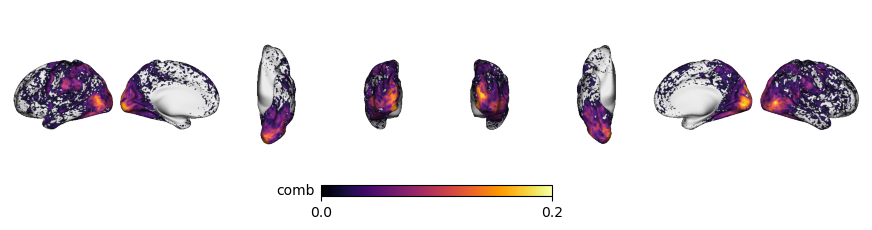

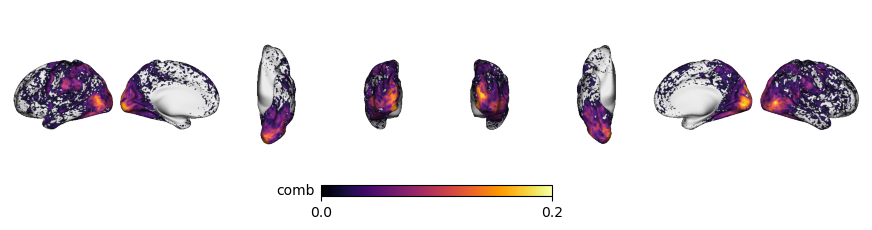

In [14]:
alignment = 'ha_common'

feature = 'comb'
bgLfname = f"{gii_dir}/{feature}-r_pca-40_align-{alignment}_hemi-lh_ttest.gii"
bgRfname = f"{gii_dir}/{feature}-r_pca-40_align-{alignment}_hemi-rh_ttest.gii"
fsaverage_to_fslr_and_plot(bgLfname, bgRfname, feature, cmap='inferno', max=.2)

## number of significant voxels

In [15]:
alignment = 'ha_common'

Lfname = f"{gii_dir}/{feature}-r_pca-40_align-{alignment}_hemi-lh_ttest.gii"
Rfname = f"{gii_dir}/{feature}-r_pca-40_align-{alignment}_hemi-rh_ttest.gii"

giiL = nib.load(Lfname)
giiR = nib.load(Rfname)

sig_voxel = np.sum(giiL.agg_data() > 0) + np.sum(giiR.agg_data() > 0) 
print(f"{feature}: {sig_voxel}")


comb: 43674


## workbench cluster threshold

In [17]:
from subprocess import call
# parameteres
hemis = ['lh', 'rh']
features = 'comb'
clustersize = 100
hemi_dict = {'lh': 'L', 'rh': 'R'}
fsaverage_dir = '/Users/h/neuromaps-data/atlases/fsaverage'
# data_dir = os.path.join(output_dir, 'stats') #'/Volumes/life-encoding/results/himalaya/glove/ha_common_pca-40/stats'

# thresholding via workbench
for hemi in hemis:
    fsaverage_template = f"{fsaverage_dir}/tpl-fsaverage_den-41k_hemi-{hemi_dict[hemi]}_inflated.surf.gii"
    himalaya = f"{gii_dir}/{feature}-r_pca-40_align-ha_common_hemi-{hemi}_ttest.gii"
    outputfname = f"{gii_dir}/full-r_acagbgmo_pca-40_align-ha_common_hemi-{hemi}_ttest_cluster-{clustersize}.gii"
    return_code = call(f"wb_command -metric-find-clusters {fsaverage_template} {himalaya} 0 {clustersize} {outputfname}", shell=True)
print(f"Return: {return_code}")

Return: 0


## check cluster threshold maps

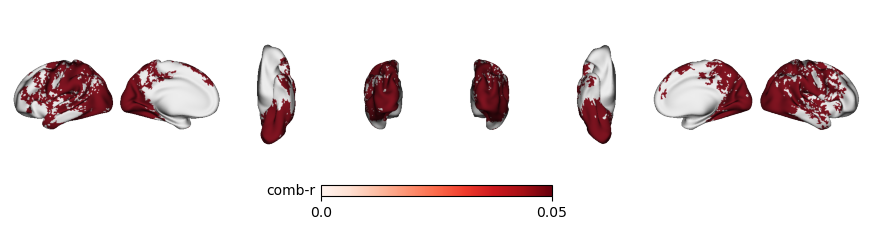

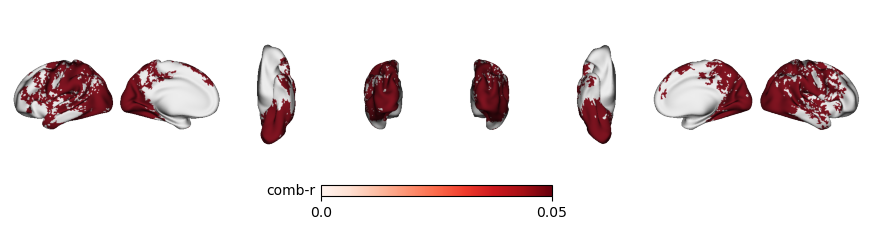

In [18]:
clusterthresL = f"{gii_dir}/{feature}-r_pca-40_align-ha_common_hemi-lh_ttest_cluster-{clustersize}.gii"
clusterthresR = f"{gii_dir}/{feature}-r_pca-40_align-ha_common_hemi-rh_ttest_cluster-{clustersize}.gii"
fsaverage_to_fslr_and_plot(clusterthresL, clusterthresR, f'{feature}-r', cmap = 'Reds')

In [19]:
def write_gifti_v2(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    # nib.gifti.write(gii, output_fn)
    gii.to_filename(output_fn)

hemis = ['lh', 'rh']
hemi_dict = {'lh': 'L', 'rh': 'R'}

fsaverage_dir = '/Users/h/neuromaps-data/atlases/fsaverage'
# data_dir = '/Volumes/life-encoding/results/himalaya/glove/ha_common_pca-40/stats'

# thresholding via workbench
for hemi in hemis:
    clustermask_fname = f"{gii_dir}/{feature}-r_pca-40_align-ha_common_hemi-{hemi}_ttest_cluster-{clustersize}.gii"
    clustL = nib.load(clustermask_fname).agg_data() > 0
    himalaya_fname = f"{gii_dir}/{feature}-r_pca-40_align-ha_common_hemi-{hemi}_ttest.gii"
    himalaya = nib.load(himalaya_fname).agg_data()
    maskeddata = clustL * himalaya
    write_gifti_v2(maskeddata.astype(np.float32), 
        output_fn=f"{gii_dir}/{feature}-r_pca-40_align-{alignment}_hemi-{hemi}_ttest_thres-cluster{clustersize}.gii",
        template_fn=f"{fsaverage_dir}/tpl-fsaverage_den-41k_hemi-{hemi_dict[hemi]}_pial.surf.gii")

# fig S2

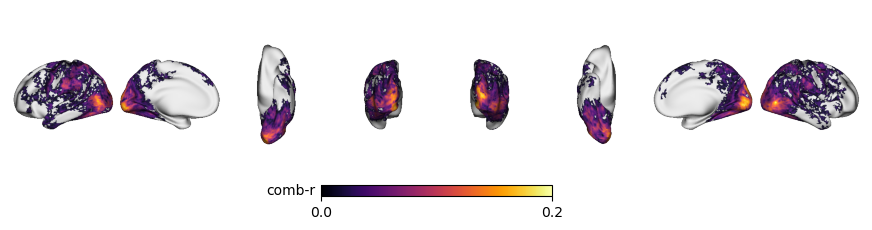

In [20]:
save_dir = f'/Users/h/Documents/projects_local/life-encoding/figure/glove/{feature}/variancepart'
save_dir = f'/Users/h/jung2heejung@gmail.com - Google Drive/My Drive/life_encoding/figure/variancepart'

r_type = 'r'
Path(save_dir).mkdir(exist_ok=True, parents=True)
thresL = f"{gii_dir}/comb-{r_type}_pca-40_align-{alignment}_hemi-lh_ttest_thres-cluster{clustersize}.gii"
thresR = f"{gii_dir}/comb-{r_type}_pca-40_align-{alignment}_hemi-rh_ttest_thres-cluster{clustersize}.gii"
fig = fsaverage_to_fslr_and_plot(thresL, thresR, f'{feature}-r', cmap='inferno',min=0, max=.2)
fig.savefig(join(save_dir, f"{features}-r_pca-40_align-{alignment}_hemi-lh_ttest_thres-cluster{clustersize}.png"), dpi=300)

# prototype
actions_agents_intersect = actions_single + agents_single - agents_actions_nested
actions_bg_intersect = actions_single + bg_single - actions_bg_nested
agents_bg_intersect = agents_single + bg_single - agents_bg_nested

# B. nested 

In [96]:
save_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'
main_dir = '/Volumes/life-encoding'
r_type = 'r'
hemis = ['lh', 'rh']
# features_dir = os.path.join(main_dir, 'results', 'himalaya', "glove_single")

feature_dict = {'agents-bg-moten': '3agbgmo', 
                'actions-bg-moten': '3acbgmo', 
                'actions-agents-moten': '3acagmo', 
                'actions-agents-bg': '3acagbg', 
                'actions-bg': '2acbg', 
                'agents-bg': '2agbg', 
                'actions-agents': '2acag',
                'actions': '1ac', 
                'agents': '1ag', 
                'bg': '1bg', 
                'moten': '1mo'}

for feature_string in ['actions-bg-moten', 'actions-agents-moten', 'agents-bg-moten',
                       'actions-agents-bg', 'actions-bg', 'agents-bg', 'actions-agents',
                        'actions', 'agents', 'bg', 'moten']:

    output_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', feature_string, 'ha_common_pca-40')
    # output_dir = os.path.join(features_dir, feature_string + '-moten', 'ha_common_pca-40')
    print(f"starting {feature_string} ________________")
    for h, hemisphere in enumerate(hemis):
        means = np.zeros((n_vertices))
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_run = []
            for test_run in runs:           

                run_data = np.load(f"{output_dir}/comb-r_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_run = np.arctanh(run_data[0, cortical_vertices])
                stack_fisherz_run.append(fisherz_run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask 
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        means[cortical_coords] = fisher_mean(fisherz_all, axis=0)
        save_fname = f"{save_dir}/nested-{r_type}_{feature_dict[feature_string]}_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_groupmean.gii"
        write_gifti_v2(means.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"{hemisphere}.pial.gii"), 
        output_fn = save_fname)
        print("* saved output (thresholded average r) for both hemispheres")



starting actions-bg-moten ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-agents-moten ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-agents-bg ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-bg ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting agents-bg ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-agents ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions _______________

In [97]:
save_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'
main_dir = '/Volumes/life-encoding'
r_type = 'r'
hemis = ['lh', 'rh']
# features_dir = os.path.join(main_dir, 'results', 'himalaya', "glove_single")

feature_dict = {'agents-bg-moten': '3agbgmo', 
                'actions-bg-moten': '3acbgmo', 
                'actions-agents-moten': '3acagmo', 
                'actions-agents-bg': '3acagbg', 
                'actions-bg': '2acbg', 
                'agents-bg': '2agbg', 
                'actions-agents': '2acag',
                'actions': '1ac', 
                'agents': '1ag', 
                'bg': '1bg', 
                'moten': '1mo'}

for feature_string in [ 'agents-bg-moten']:

    output_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', feature_string, 'ha_common_pca-40')
    # output_dir = os.path.join(features_dir, feature_string + '-moten', 'ha_common_pca-40')
    print(f"starting {feature_string} ________________")
    for h, hemisphere in enumerate(hemis):
        means = np.zeros((n_vertices))
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_run = []
            for test_run in runs:           

                run_data = np.load(f"{output_dir}/comb-r_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_run = np.arctanh(run_data[0, cortical_vertices])
                stack_fisherz_run.append(fisherz_run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask 
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        means[cortical_coords] = fisher_mean(fisherz_all, axis=0)
        save_fname = f"{save_dir}/nested-{r_type}_{feature_dict[feature_string]}_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_groupmean.gii"
        write_gifti_v2(means.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"{hemisphere}.pial.gii"), 
        output_fn = save_fname)
        print("* saved output (thresholded average r) for both hemispheres")



starting agents-bg-moten ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres


# C. 2 feature model

In [89]:
save_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'
main_dir = '/Volumes/life-encoding'
r_type = 'r'
hemis = ['lh', 'rh']
features_dir = os.path.join(main_dir, 'results', 'himalaya', "glove_single")
feature_dict = {'actions': '2acmo',
                'agents': '2agmo', 
                'bg': '2bgmo'}
for feature_string in [ 'actions', 'agents', 'bg']: 
    output_dir = os.path.join(features_dir, feature_string + '-moten', 'ha_common_pca-40')
    print(f"starting {feature_string} ________________")
    for h, hemisphere in enumerate(hemis):
        means = np.zeros((n_vertices))
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_run = []
            for test_run in runs:           

                run_data = np.load(f"{output_dir}/comb-r_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_run = np.arctanh(run_data[0, cortical_vertices])
                stack_fisherz_run.append(fisherz_run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask 
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        means[cortical_coords] = fisher_mean(fisherz_all, axis=0)
        save_fname = f"{save_dir}/nested-{r_type}_{feature_dict[feature_string]}_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_groupmean.gii"
        write_gifti_v2(means.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"{hemisphere}.pial.gii"), 
        output_fn = save_fname)
        print("* saved output (thresholded average r) for both hemispheres")



starting actions ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting agents ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting bg ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres


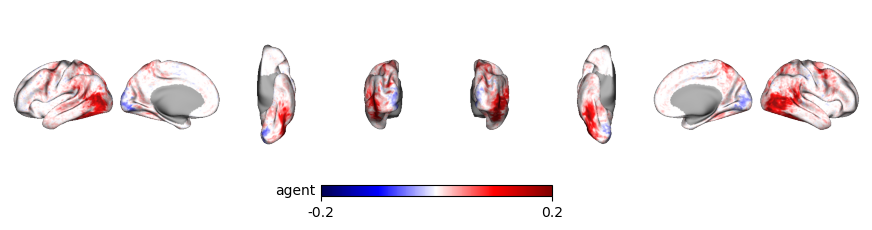

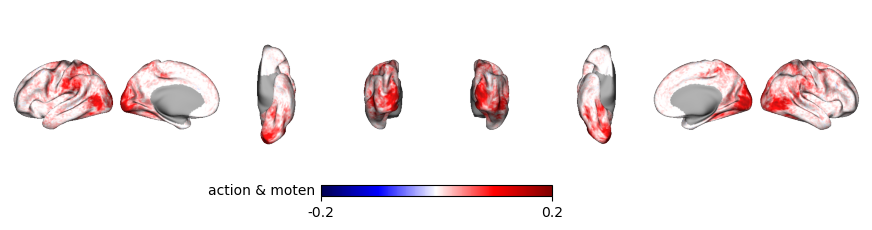

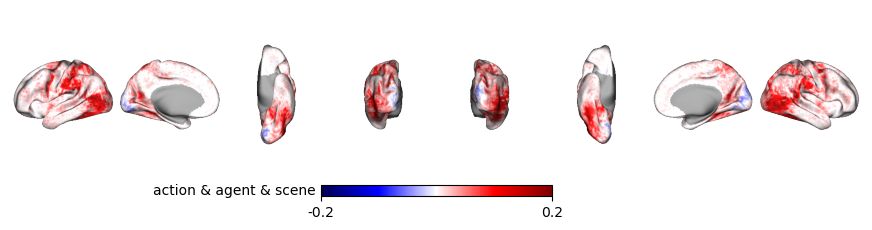

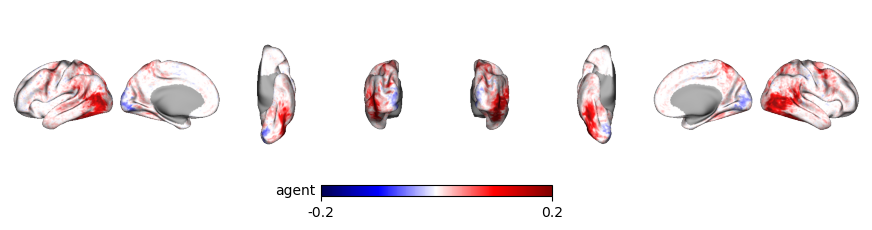

In [99]:
meanimg_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'

# three combinations
#3acagbg
f2_acmo_L_fname = join(meanimg_dir,'nested-r_2acmo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f2_acmo_R_fname = join(meanimg_dir,'nested-r_2acmo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
fsaverage_to_fslr_and_plot(f2_acmo_L_fname, f2_acmo_R_fname, 'action & moten', cmap='seismic',min=-.2,  max=.2)

f3_acagbg_L_fname = join(meanimg_dir,'nested-r_3acagbg_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f3_acagbg_R_fname = join(meanimg_dir,'nested-r_3acagbg_pca-40_align-ha_common_hemi-rh_groupmean.gii')
fsaverage_to_fslr_and_plot(f3_acagbg_L_fname, f3_acagbg_R_fname, 'action & agent & scene', cmap='seismic',min=-.2,  max=.2)

f1_ag_L_fname = join(meanimg_dir,'nested-r_1ag_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f1_ag_R_fname = join(meanimg_dir,'nested-r_1ag_pca-40_align-ha_common_hemi-rh_groupmean.gii')
fsaverage_to_fslr_and_plot(f1_ag_L_fname, f1_ag_R_fname, 'agent', cmap='seismic', min=-.2, max=.2)

# variance partitioning
load combinatoric models of model performance

In [23]:
meanimg_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'

#4acagbg
f4_acagbgmo_L_fname = join(meanimg_dir,'full-r_acagbgmo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f4_acagbgmo_R_fname = join(meanimg_dir,'full-r_acagbgmo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f4_comb_L = nib.load(f4_acagbgmo_L_fname).agg_data()
f4_comb_R = nib.load(f4_acagbgmo_R_fname).agg_data()
f4_comb_L[f4_comb_L <= 0] = 0
f4_comb_R[f4_comb_R <= 0] = 0
maskL = nib.load(join(meanimg_dir, 'full-r_acagbgmo_pca-40_align-ha_common_hemi-lh_ttest.gii')).agg_data().astype('bool')
maskR = nib.load(join(meanimg_dir, 'full-r_acagbgmo_pca-40_align-ha_common_hemi-lh_ttest.gii')).agg_data().astype('bool')

In [24]:
def load_groupmean(meanimg_dir, feature_string):
    L_fname = glob.glob(join(meanimg_dir,f'*_{feature_string}_pca-40_align-ha_common_hemi-lh_groupmean.gii'))
    R_fname = glob.glob(join(meanimg_dir,f'*_{feature_string}_pca-40_align-ha_common_hemi-rh_groupmean.gii'))
    Larray = nib.load(L_fname[0]).agg_data()
    Rarray = nib.load(R_fname[0]).agg_data()
    Larray[Larray <= 0] = 0
    Rarray[Rarray <= 0] = 0
    return Larray, Rarray

### load data

In [25]:
meanimg_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'

f4_comb_L,f4_comb_R  = load_groupmean(meanimg_dir, 'acagbgmo')

f3_acagbg_L,f3_acagbg_R  = load_groupmean(meanimg_dir, '3acagbg')
f3_acagmo_L,f3_acagmo_R  = load_groupmean(meanimg_dir, '3acagmo')
f3_acbgmo_L,f3_acbgmo_R  = load_groupmean(meanimg_dir, '3acbgmo')
f3_agbgmo_L,f3_agbgmo_R  = load_groupmean(meanimg_dir, '3agbgmo')

f2_acag_L,f2_acag_R  = load_groupmean(meanimg_dir, '2acag')
f2_acbg_L,f2_acbg_R  = load_groupmean(meanimg_dir, '2acbg')
f2_acmo_L,f2_acmo_R  = load_groupmean(meanimg_dir, '2acmo')
f2_agbg_L,f2_agbg_R  = load_groupmean(meanimg_dir, '2agbg')
f2_agmo_L,f2_agmo_R  = load_groupmean(meanimg_dir, '2agmo')
f2_bgmo_L,f2_bgmo_R  = load_groupmean(meanimg_dir, '2bgmo')

f1_ac_L,f1_ac_R  = load_groupmean(meanimg_dir, '1ac')
f1_ag_L,f1_ag_R  = load_groupmean(meanimg_dir, '1ag')
f1_bg_L,f1_bg_R  = load_groupmean(meanimg_dir, '1bg')
f1_mo_L,f1_mo_R  = load_groupmean(meanimg_dir, '1mo')

### calculate partitioned variance

In [26]:
# 12 = -24 + 134 + 234 - 1234
# 13 = -24 + 124 + 234 - 1234
# 14 = -23 + 123 + 234 - 1234
# 23 = -14 + 124 + 134 - 1234
# 24 = -13 + 123 - 134 - 1234
# 34 = -12 +123 + 124 - 1234
# 123 = -4 + 14 + 24 + 34 - 124 - 134 - 234 +1234
# 124 = -3 +13 + 23 + 34 -123 -134 -234 + 1234
# 134 = -2 + 12 + 23 + 24 - 123 - 124 - 234 + 1234
# 234 = -1 + 12 + 13 - 14 -123 -124 -134 + 1234
# 1234 = 1 + 2 + 3 + 4 -12 -13 -14 -23 -24 -34 + 123 + 124 + 134 + 234 - 1234

# acag = -agmo + acbgmo + agbgmo - acagbgmo
# acbg = -agmo + acagmo + agbgmo - acagbgmo
# acmo = -agbg + acagbg + agbgmo - acagbgmo
# agbg = -acmo + acagmo + acbgmo - acagbgmo
# agmo = -acbg + acagbg - acbgmo - acagbgmo
# bgmo = -acag +acagbg + acagmo - acagbgmo
# acagbg = -mo + acmo + agmo + bgmo - acagmo - acbgmo - agbgmo +acagbgmo
# acagmo = -bg +acbg + agbg + bgmo -acagbg -acbgmo -agbgmo + acagbgmo
# acbgmo = -ag + acag + agbg + agmo - acagbg - acagmo - agbgmo + acagbgmo
# agbgmo = -ac + acag + acbg - acmo -acagbg -acagmo -acbgmo + acagbgmo
# acagbgmo = ac + ag + bg + mo -acag -acbg -acmo -agbg -agmo -bgmo + acagbg + acagmo + acbgmo + agbgmo - acagbgmo

vp1_ac_L = f4_comb_L - f3_agbgmo_L
vp1_ag_L = f4_comb_L - f3_acbgmo_L
vp1_bg_L = f4_comb_L - f3_acagmo_L
vp1_mo_L = f4_comb_L - f3_acagbg_L
vp2_acag_L = -f2_agmo_L + f3_acbgmo_L + f3_agbgmo_L - f4_comb_L
vp2_acbg_L = -f2_agmo_L + f3_acagmo_L + f3_agbgmo_L - f4_comb_L
vp2_acmo_L = -f2_agbg_L + f3_acagbg_L + f3_agbgmo_L - f4_comb_L
vp2_agbg_L = -f2_acmo_L + f3_acagmo_L + f3_acbgmo_L - f4_comb_L
vp2_agmo_L = -f2_acbg_L + f3_acagbg_L - f3_acbgmo_L - f4_comb_L
vp2_bgmo_L = -f2_acag_L + f3_acagbg_L + f3_acagmo_L - f4_comb_L
vp3_acagbg_L = -f1_mo_L + f2_acmo_L + f2_agmo_L + f2_bgmo_L - f3_acagmo_L - f3_acbgmo_L - f3_agbgmo_L + f4_comb_L
vp3_acagmo_L = -f1_bg_L + f2_acbg_L + f2_agbg_L + f2_bgmo_L - f3_acagbg_L - f3_acbgmo_L - f3_agbgmo_L + f4_comb_L
vp3_acbgmo_L = -f1_ag_L + f2_acag_L + f2_agbg_L + f2_agmo_L - f3_acagbg_L - f3_acagmo_L - f3_agbgmo_L + f4_comb_L
vp3_agbgmo_L = -f1_ac_L + f2_acag_L + f2_acbg_L - f2_acmo_L - f3_acagbg_L - f3_acagmo_L - f3_acbgmo_L + f4_comb_L
vp4_acagbgmo_L = f1_ac_L + f1_ag_L + f1_bg_L + f1_mo_L - f2_acag_L - f2_acbg_L - f2_acmo_L - f2_agbg_L - f2_agmo_L - f2_bgmo_L + f3_acagbg_L + f3_acagmo_L + f3_acbgmo_L + f3_agbgmo_L - f4_comb_L

vp1_ac_R = f4_comb_R - f3_agbgmo_R
vp1_ag_R = f4_comb_R - f3_acbgmo_R
vp1_bg_R = f4_comb_R - f3_acagmo_R
vp1_mo_R = f4_comb_R - f3_acagbg_R
vp2_acag_R = -f2_agmo_R + f3_acbgmo_R + f3_agbgmo_R - f4_comb_R
vp2_acbg_R = -f2_agmo_R + f3_acagmo_R + f3_agbgmo_R - f4_comb_R
vp2_acmo_R = -f2_agbg_R + f3_acagbg_R + f3_agbgmo_R - f4_comb_R
vp2_agbg_R = -f2_acmo_R + f3_acagmo_R + f3_acbgmo_R - f4_comb_R
vp2_agmo_R = -f2_acbg_R + f3_acagbg_R - f3_acbgmo_R - f4_comb_R
vp2_bgmo_R = -f2_acag_R + f3_acagbg_R + f3_acagmo_R - f4_comb_R
vp3_acagbg_R = -f1_mo_R + f2_acmo_R + f2_agmo_R + f2_bgmo_R - f3_acagmo_R - f3_acbgmo_R - f3_agbgmo_R + f4_comb_R
vp3_acagmo_R = -f1_bg_R + f2_acbg_R + f2_agbg_R + f2_bgmo_R - f3_acagbg_R - f3_acbgmo_R - f3_agbgmo_R + f4_comb_R
vp3_acbgmo_R = -f1_ag_R + f2_acag_R + f2_agbg_R + f2_agmo_R - f3_acagbg_R - f3_acagmo_R - f3_agbgmo_R + f4_comb_R
vp3_agbgmo_R = -f1_ac_R + f2_acag_R + f2_acbg_R - f2_acmo_R - f3_acagbg_R - f3_acagmo_R - f3_acbgmo_R + f4_comb_R
vp4_acagbgmo_R = f1_ac_R + f1_ag_R + f1_bg_R + f1_mo_R - f2_acag_R - f2_acbg_R - f2_acmo_R - f2_agbg_R - f2_agmo_R - f2_bgmo_R + f3_acagbg_R + f3_acagmo_R + f3_acbgmo_R + f3_agbgmo_R - f4_comb_R


## calculate argmax values

In [27]:
import numpy as np

array_dict_L = {
    'vp1_ac_L': vp1_ac_L,
    'vp1_ag_L': vp1_ag_L,
    'vp1_bg_L': vp1_bg_L,
    'vp1_mo_L': vp1_mo_L,
    'vp2_acag_L': vp2_acag_L,
    'vp2_acbg_L': vp2_acbg_L,
    'vp2_acmo_L': vp2_acmo_L,
    'vp2_agbg_L': vp2_agbg_L,
    'vp2_agmo_L': vp2_agmo_L,
    'vp2_bgmo_L': vp2_bgmo_L,
    'vp3_acagbg_L': vp3_acagbg_L,
    'vp3_acagmo_L': vp3_acagmo_L,
    'vp3_acbgmo_L': vp3_acbgmo_L,
    'vp3_agbgmo_L': vp3_agbgmo_L,
    'vp4_acagbgmo_L': vp4_acagbgmo_L
}



array_dict_R = {
    'vp1_ac_R': vp1_ac_R,
    'vp1_ag_R': vp1_ag_R,
    'vp1_bg_R': vp1_bg_R,
    'vp1_mo_R': vp1_mo_R,
    'vp2_acag_R': vp2_acag_R,
    'vp2_acbg_R': vp2_acbg_R,
    'vp2_acmo_R': vp2_acmo_R,
    'vp2_agbg_R': vp2_agbg_R,
    'vp2_agmo_R': vp2_agmo_R,
    'vp2_bgmo_R': vp2_bgmo_R,
    'vp3_acagbg_R': vp3_acagbg_R,
    'vp3_acagmo_R': vp3_acagmo_R,
    'vp3_acbgmo_R': vp3_acbgmo_R,
    'vp3_agbgmo_R': vp3_agbgmo_R,
    'vp4_acagbgmo_R': vp4_acagbgmo_R
}

combination_listL = ['vp1_ac_L', 'vp1_ag_L', 'vp1_bg_L', 'vp1_mo_L', 'vp2_acag_L', 'vp2_acbg_L', 'vp2_acmo_L', 'vp2_agbg_L', 'vp2_agmo_L', 'vp2_bgmo_L', 'vp3_acagbg_L', 'vp3_acagmo_L', 'vp3_acbgmo_L', 'vp3_agbgmo_L', 'vp4_acagbgmo_L']
combination_listR = ['vp1_ac_R', 'vp1_ag_R', 'vp1_bg_R', 'vp1_mo_R', 'vp2_acag_R', 'vp2_acbg_R', 'vp2_acmo_R', 'vp2_agbg_R', 'vp2_agmo_R', 'vp2_bgmo_R', 'vp3_acagbg_R', 'vp3_acagmo_R', 'vp3_acbgmo_R', 'vp3_agbgmo_R', 'vp4_acagbgmo_R']


# argmax stacked values

stacked_L = np.stack([array_dict_L[l] for l in combination_listL], axis=0) # Stack the arrays
argmax_indices_L = np.argmax(stacked_L, axis=0)  # Perform argmax column-wise 

stacked_R = np.stack([array_dict_R[l] for l in combination_listR], axis=0) # Stack the arrays
argmax_indices_R = np.argmax(stacked_R, axis=0) # Perform argmax column-wise 





Argmax column-wise result (names): ['f3_acagmo_L', 'f3_acagmo_L', 'f3_acagmo_L', 'f3_acagmo_L', 'f3_acagmo_L', 'f2_bgmo_L', 'f3_acagmo_L',
Argmax column-wise result (names): ['f3_acagbg_R', 'f2_bgmo_R', 'f1_ac_R', 'f3_acagmo_R', 'f3_acagbg_R', 'f2_bgmo_R', 'f3_acagmo_R',

### apply nonmedial mask & significant map (full-r acagbgmo)

In [28]:
fullgifti_L = nib.load('/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-40_align-ha_common_hemi-lh_ttest_cluster-100.gii').agg_data()
fullgifti_R = nib.load('/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-40_align-ha_common_hemi-rh_ttest_cluster-100.gii').agg_data()
main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding'
main_dir = '/Volumes/life-encoding'
medial_mask_L = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_lh.npy'))
medial_mask_R = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_rh.npy'))


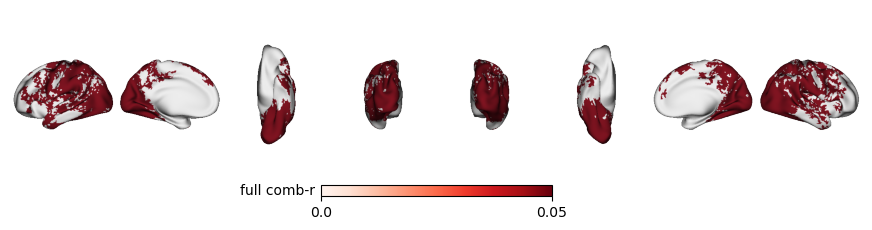

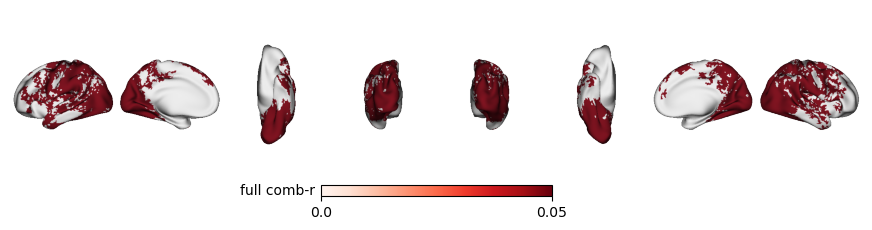

In [29]:
fsaverage_to_fslr_and_plot('/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-40_align-ha_common_hemi-lh_ttest_cluster-100.gii',
                           '/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-40_align-ha_common_hemi-rh_ttest_cluster-100.gii', 
                           cmap='Reds', key='full comb-r')

In [30]:

print(combination_listL)
print(np.unique((argmax_indices_L+1), return_counts=True))

['vp1_ac_L', 'vp1_ag_L', 'vp1_bg_L', 'vp1_mo_L', 'vp2_acag_L', 'vp2_acbg_L', 'vp2_acmo_L', 'vp2_agbg_L', 'vp2_agmo_L', 'vp2_bgmo_L', 'vp3_acagbg_L', 'vp3_acagmo_L', 'vp3_acbgmo_L', 'vp3_agbgmo_L', 'vp4_acagbgmo_L']
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([ 7012,   464,   402,  3368,  1778,   623,  1832,   593,   148,
        1214,  1835,  3608,  3052,   286, 14747]))


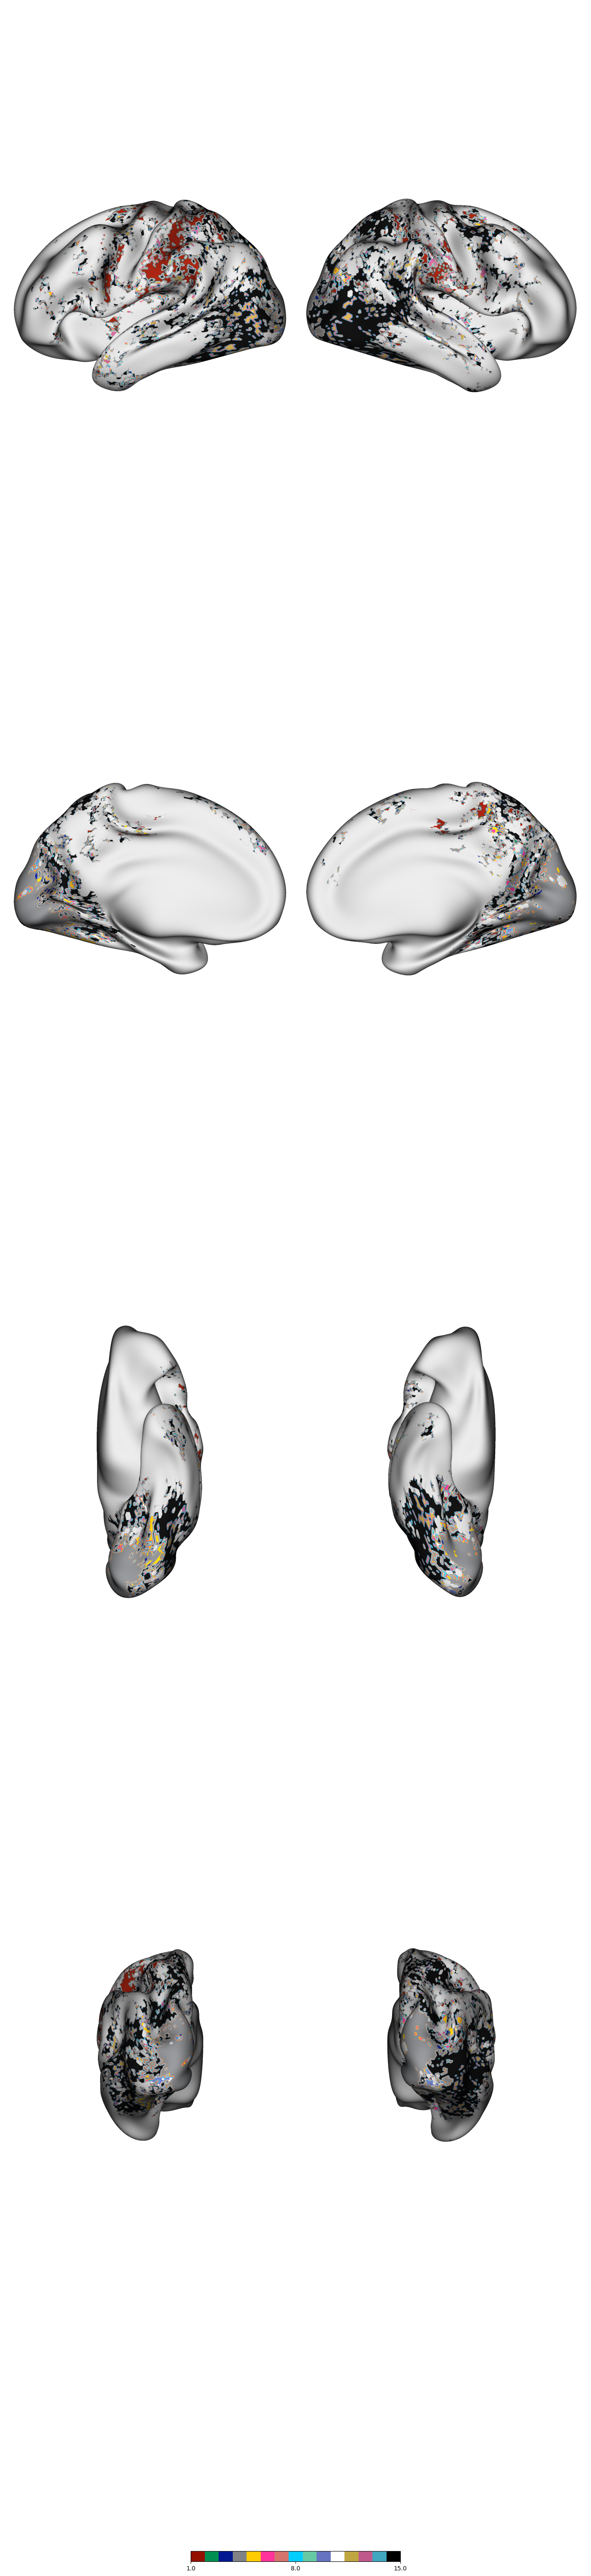

In [31]:
argmax_masked_L = (argmax_indices_L + 1) * ~medial_mask_L * fullgifti_L.astype(bool) 
argmax_masked_R = (argmax_indices_R + 1) * ~medial_mask_R * fullgifti_R.astype(bool) 

# masked_agbg_L = (argmax_masked_L_subset == 6)
gii_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition/'
suma_dir = '/Users/h/suma-fsaverage6'
main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding'
main_dir = '/Volumes/life-encoding'
write_gifti_v2(argmax_masked_L.astype(np.float32), 
    output_fn=f"{gii_dir}/argmax_full-15.lh.gii",
    template_fn = os.path.join(suma_dir, f"lh.pial.gii"))

# masked_agbg_R = (argmax_masked_R_subset == 6)
write_gifti_v2(argmax_masked_R.astype(np.float32), 
    output_fn=f"{gii_dir}/argmax_full-15.rh.gii",
    template_fn = os.path.join(suma_dir, f"rh.pial.gii"))

import numpy as np
import nibabel as nib
from os.path import join



def plot_category(giiLfname, giiRfname):
    from neuromaps.datasets import fetch_fslr
    from neuromaps.transforms import fsaverage_to_fslr
    from surfplot import Plot
    from matplotlib.colors import ListedColormap
    # NOTE 1: Define the palette (shared across left and right hemispheres)
    palette = {

        '1': '#941100', # red
        '2': '#008F51', # green
        '3': '#011891', # blue
        '4': '#808285', # gray
        '5': '#FFCC00', #yellow
        '6': '#ff3399', #pink
        '7': '#D4746D', #red + gray
        '8': '#02CDFF', # cyan
        '9': '#66C9A3', # green + gray
        '10': '#6573C1',# blue + gray
        '11': '#ffffff',# white
        '12': '#BFA640',# yello gray
        '13': '#BF598C',# pink + gray
        '14': '#41A6C0',# cyan + gray
        '15': '#000000',# white
    }
    # NOTE 2: Load the fsLR surfaces for plotting
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']

    # NOTE 3: Load the GIFTI files and convert to fsLR
    # giiL = nib.load(join('/Users/h/Desktop', "TST_argmax.lh.gii"))
    # giiR = nib.load(join('/Users/h/Desktop', "TST_argmax.rh.gii"))
    giiL = nib.load(giiLfname)
    giiR = nib.load(giiRfname)
    cmap = ListedColormap(palette.values())

    # TODO: ISSUE. fsaverage_to_fslr transformation turns the integers into values...
    # resampling creates an issue - we may have to create separate gifti files per combination (acbgmo, acbg, etc)
    # and transform them one by one.
    L_fslr = fsaverage_to_fslr(giiL, target_density='32k', hemi='L', method='nearest')
    R_fslr = fsaverage_to_fslr(giiR, target_density='32k', hemi='R', method='nearest')

    # NOTE 4: Plot the data
    p = Plot(lh_fslr, rh_fslr, 
             size=(2000, 8000), 
             zoom=1.2,
             brightness=.7,
             views=['lateral', 'medial', 'ventral', 'posterior'])
    p.add_layer({'left': L_fslr[0], 'right': R_fslr[0]}, cmap=cmap, cbar=True, 
                color_range=(1,15), zero_transparent=True) #, color_range=(1,20))

    p.build()
    plt.show()
    return L_fslr

L_fslrrreturn = plot_category(join(gii_dir, "argmax_full-15.lh.gii"), 
                           join(gii_dir, "argmax_full-15.rh.gii"))


In [32]:
print(combination_listL)
print(np.unique(argmax_masked_L, return_counts=True))

print(combination_listR)
print(np.unique(argmax_masked_R, return_counts=True))

['vp1_ac_L', 'vp1_ag_L', 'vp1_bg_L', 'vp1_mo_L', 'vp2_acag_L', 'vp2_acbg_L', 'vp2_acmo_L', 'vp2_agbg_L', 'vp2_agmo_L', 'vp2_bgmo_L', 'vp3_acagbg_L', 'vp3_acagmo_L', 'vp3_acbgmo_L', 'vp3_agbgmo_L', 'vp4_acagbgmo_L']
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([21768,  2872,   253,   239,  2585,   726,   153,   715,   187,
           3,   454,   615,  1794,  1258,    22,  7318]))
['vp1_ac_R', 'vp1_ag_R', 'vp1_bg_R', 'vp1_mo_R', 'vp2_acag_R', 'vp2_acbg_R', 'vp2_acmo_R', 'vp2_agbg_R', 'vp2_agmo_R', 'vp2_bgmo_R', 'vp3_acagbg_R', 'vp3_acagmo_R', 'vp3_acbgmo_R', 'vp3_agbgmo_R', 'vp4_acagbgmo_R']
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([21125,  2112,   222,   256,  3001,   756,   252,   801,   179,
           4,   551,   589,  1763,  1395,    35,  7921]))


## plotting mask

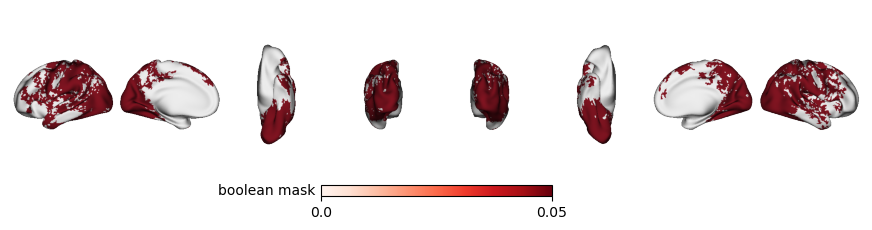

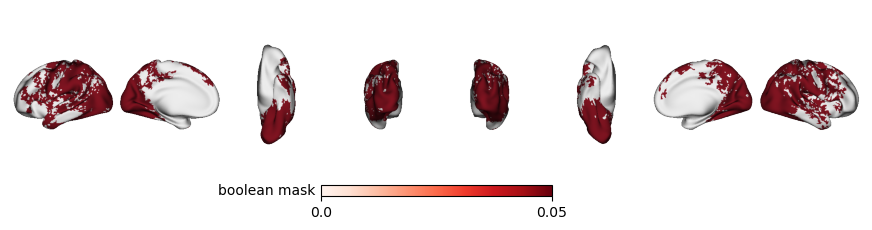

: 

In [33]:
Lmask = ~medial_mask_L * fullgifti_L.astype(bool)
suma_dir = '/Users/h/suma-fsaverage6'
save_fname = f"/Volumes/life-encoding/results/himalaya/glove_variancepartition/mask_nonmedial_fullr_L.gii"
write_gifti_v2(Lmask.astype(np.float32),
template_fn = os.path.join(suma_dir, f"lh.pial.gii"), 
output_fn = save_fname)

Rmask = ~medial_mask_R* fullgifti_R.astype(bool)
save_fname = f"/Volumes/life-encoding/results/himalaya/glove_variancepartition/mask_nonmedial_fullr_R.gii"
write_gifti_v2(Rmask.astype(np.float32),
template_fn = os.path.join(suma_dir, f"rh.pial.gii"), 
output_fn = save_fname)

fsaverage_to_fslr_and_plot("/Volumes/life-encoding/results/himalaya/glove_variancepartition/mask_nonmedial_fullr_L.gii", 
                           "/Volumes/life-encoding/results/himalaya/glove_variancepartition/mask_nonmedial_fullr_R.gii", f'boolean mask', cmap = 'Reds')

## without moten

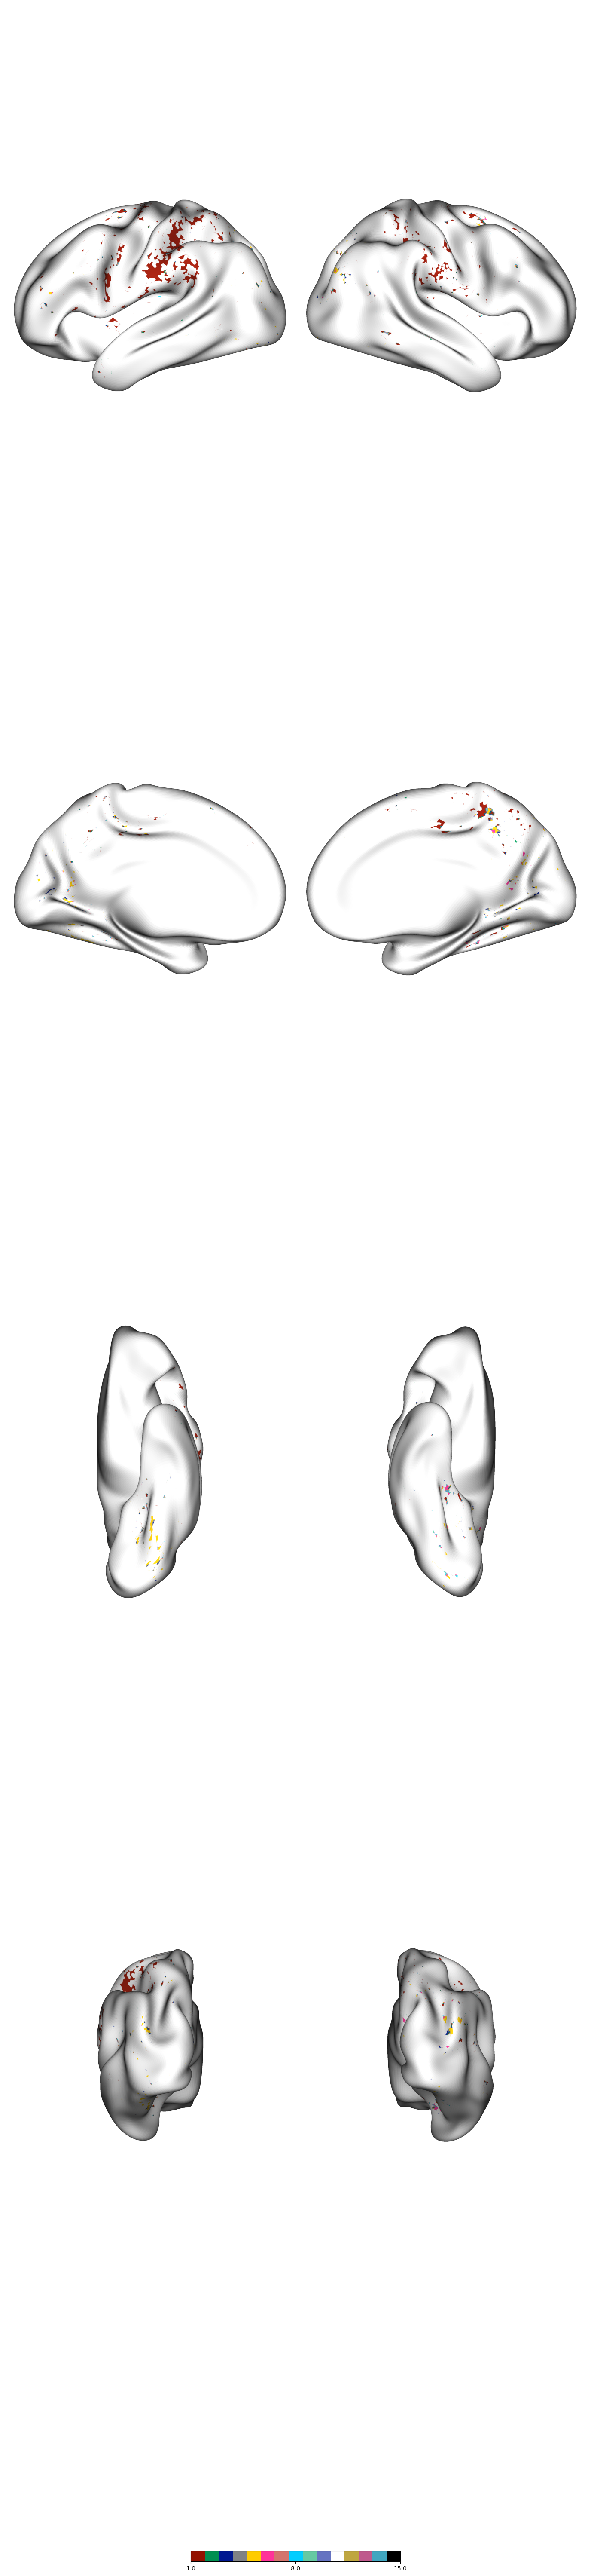

In [18]:
argmax_masked_L = (argmax_indices_L + 1) * ~medial_mask_L * fullgifti_L.astype(bool) 
argmax_masked_R = (argmax_indices_R + 1) * ~medial_mask_R * fullgifti_R.astype(bool) 


import numpy as np
import nibabel as nib
from os.path import join
feature_list = ['vp1_ac_L', 'vp1_ag_L', 'vp1_bg_L', 'vp1_mo_L', 'vp2_acag_L', 'vp2_acbg_L', 'vp2_acmo_L', 'vp2_agbg_L', 'vp2_agmo_L', 'vp2_bgmo_L', 'vp3_acagbg_L', 'vp3_acagmo_L', 'vp3_acbgmo_L', 'vp3_agbgmo_L', 'vp4_acagbgmo_L']
mo_index = [ind+1 for ind, string in enumerate(feature_list) if 'mo' in string]

argmax_masked_L_subset = argmax_masked_L.copy()
argmax_masked_R_subset = argmax_masked_R.copy()
for ind in mo_index:
    argmax_masked_L_subset[argmax_masked_L_subset == ind] = 0
    argmax_masked_R_subset[argmax_masked_R_subset == ind] = 0


gii_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition/'
write_gifti_v2(argmax_masked_L_subset.astype(np.float32), 
    output_fn=f"{gii_dir}/argmax_subset-mo.lh.gii",
    template_fn = os.path.join(suma_dir, f"lh.pial.gii"))


write_gifti_v2(argmax_masked_R_subset.astype(np.float32), 
    output_fn=f"{gii_dir}/argmax_subset-mo.rh.gii",
    template_fn = os.path.join(suma_dir, f"rh.pial.gii"))
def plot_category(giiLfname, giiRfname):
    from neuromaps.datasets import fetch_fslr
    from neuromaps.transforms import fsaverage_to_fslr
    from surfplot import Plot
    from matplotlib.colors import ListedColormap
    # NOTE 1: Define the palette (shared across left and right hemispheres)
    palette = {

        '1': '#941100', # red
        '2': '#008F51', # green
        '3': '#011891', # blue
        '4': '#808285', # gray
        '5': '#FFCC00', #yellow
        '6': '#ff3399', #pink
        '7': '#D4746D', #red + gray
        '8': '#02CDFF', # cyan
        '9': '#66C9A3', # green + gray
        '10': '#6573C1',# blue + gray
        '11': '#ffffff',# white
        '12': '#BFA640',# yello gray
        '13': '#BF598C',# pink + gray
        '14': '#41A6C0',# cyan + gray
        '15': '#000000',# white
    }
    # NOTE 2: Load the fsLR surfaces for plotting
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']

    # NOTE 3: Load the GIFTI files and convert to fsLR
    # giiL = nib.load(join('/Users/h/Desktop', "TST_argmax.lh.gii"))
    # giiR = nib.load(join('/Users/h/Desktop', "TST_argmax.rh.gii"))
    giiL = nib.load(giiLfname)
    giiR = nib.load(giiRfname)
    cmap = ListedColormap(palette.values())

    # TODO: ISSUE. fsaverage_to_fslr transformation turns the integers into values...
    # resampling creates an issue - we may have to create separate gifti files per combination (acbgmo, acbg, etc)
    # and transform them one by one.
    L_fslr = fsaverage_to_fslr(giiL, target_density='32k', hemi='L', method='nearest')
    R_fslr = fsaverage_to_fslr(giiR, target_density='32k', hemi='R', method='nearest')

    # NOTE 4: Plot the data
    p = Plot(lh_fslr, rh_fslr, 
             size=(2000, 8000), 
             zoom=1.2,
             brightness=.7,
             views=['lateral', 'medial', 'ventral', 'posterior'])
    p.add_layer({'left': L_fslr[0], 'right': R_fslr[0]}, cmap=cmap, cbar=True, 
                color_range=(1,15), zero_transparent=True) #, color_range=(1,20))

    p.build()
    plt.show()
    return L_fslr

L_fslrrreturn = plot_category(join(gii_dir, "argmax_subset-mo.lh.gii"), 
                           join(gii_dir, "argmax_subset-mo.rh.gii"))


['vp1_ac_L', 'vp1_ag_L', 'vp1_bg_L', 'vp1_mo_L', 'vp2_acag_L', 'vp2_acbg_L', 'vp2_acmo_L', 'vp2_agbg_L', 'vp2_agmo_L', 'vp2_bgmo_L', 'vp3_acagbg_L', 'vp3_acagmo_L', 'vp3_acbgmo_L', 'vp3_agbgmo_L', 'vp4_acagbgmo_L']
(array([ 0,  1,  2,  3,  5,  6,  8, 11]), array([35917,  2872,   253,   239,   726,   153,   187,   615]))
(array([ 0,  1,  2,  3,  5,  6,  8, 11]), array([36596,  2112,   222,   256,   756,   252,   179,   589]))
[72513  4984   475   495  1482   405   366  1204]


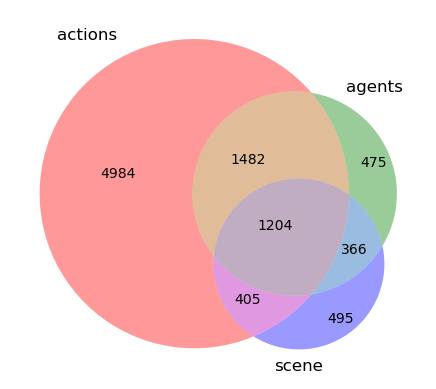

In [19]:

print(['vp1_ac_L', 'vp1_ag_L', 'vp1_bg_L', 'vp1_mo_L', 'vp2_acag_L', 'vp2_acbg_L', 'vp2_acmo_L', 'vp2_agbg_L', 'vp2_agmo_L', 'vp2_bgmo_L', 'vp3_acagbg_L', 'vp3_acagmo_L', 'vp3_acbgmo_L', 'vp3_agbgmo_L', 'vp4_acagbgmo_L'])
print(np.unique(argmax_masked_L_subset, return_counts=True))
print(np.unique(argmax_masked_R_subset, return_counts=True))
argmax_masked_total_subset = np.unique(argmax_masked_L_subset, return_counts=True)[1] + np.unique(argmax_masked_R_subset, return_counts=True)[1]
print(argmax_masked_total_subset)
# (Abc, aBc, ABc, abC, AbC, aBC, ABC)
# (ac, ag, acag, bg, acbg, agbg, acagbg)
# ['vp1_ac_L', 'vp1_ag_L', 'vp2_acbg_L','vp1_bg_L', 'vp2_acbg_L',  'vp2_agbg_L','vp3_acagbg_L')
 
#  'vp1_bg_L', 'vp1_mo_L', 'vp2_acag_L', 'vp2_acbg_L', 'vp2_acmo_L', 'vp2_agbg_L', 'vp2_agmo_L', 'vp2_bgmo_L', 'vp3_acagbg_L', 'vp3_acagmo_L', 'vp3_acbgmo_L', 'vp3_agbgmo_L', 'vp4_acagbgmo_L'])
#       print(combination_listL)
# print(np.unique(argmax_masked_L, return_counts=True))

# 0 1 2 3 5 6 8 11
['vp1_ac_L', 'vp1_ag_L', 'vp1_bg_L', 'vp2_acag_L', 'vp2_acbg_L','vp2_agbg_L','vp3_acagbg_L']
[4984,   475 ,  495,  1482 ,  405 ,  366 , 1204]

new_dict = {
    "ac":4984,
    "ag":475,
    "bg":495,
    "acag":1482,
    "acbg":405,
    "agbg":366,
    "acagbg":1204
}
from matplotlib_venn import venn3
venn3(subsets = (new_dict['ac'], new_dict['ag'], new_dict['acag'], new_dict['bg'], new_dict['acbg'], new_dict['agbg'], new_dict['acagbg']), set_labels = ('actions', 'agents', 'scene'))


In [20]:

print(f"min: {np.min(f3_acbgmo_R)}, max: {np.max(f3_acbgmo_R)}")

min: 0.0, max: 0.20147469639778137


In [21]:
print(f"min: {np.min(stacked_L)}, max: {np.max(stacked_L)}")
print(f"min: {np.min(argmax_masked_L)}, max: {np.max(argmax_masked_L)}")

min: -0.4161074161529541, max: 0.1807168871164322
min: 0, max: 15


In [27]:
argmax_masked_L


array([0, 5, 0, ..., 0, 0, 0])

## calculate argmax

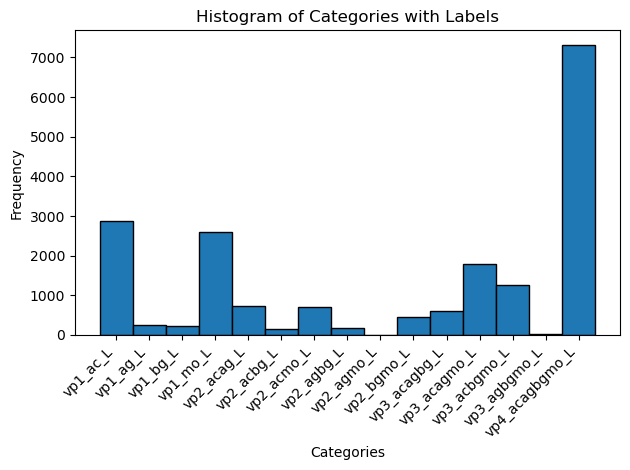

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming giiL.agg_data() contains the numeric data from 0 to 14
# data = giiL.agg_data()

# Palette with labels corresponding to numbers 1-14
palette = {
    1: 'vp1_ac_L',
    2: 'vp1_ag_L',
    3: 'vp1_bg_L',
    4: 'vp1_mo_L',
    5: 'vp2_acag_L', # yellow
    6: 'vp2_acbg_L', # pink
    7: 'vp2_acmo_L', #red + gray
    8: 'vp2_agbg_L', # # cyan + 
    9: 'vp2_agmo_L', # green + gray
    10: 'vp2_bgmo_L', # blue + gray
    11: 'vp3_acagbg_L', # white
    12: 'vp3_acagmo_L',
    13: 'vp3_acbgmo_L', # pink + gray
    14: 'vp3_agbgmo_L', #cyan + gray
    15: 'vp4_acagbgmo_L' # white
}




# Create the histogram
plt.hist(argmax_masked_L, bins=np.arange(0.5, 16.5, 1), edgecolor='black')

# Set the tick marks to correspond to the categories
plt.xticks(ticks=np.arange(1, 16), labels=[palette[i] for i in range(1, 16)], rotation=45, ha="right")

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Frequency")
plt.title("Histogram of Categories with Labels")

# Display the plot
plt.tight_layout()
plt.show()


## confirming that the unique and combinatoric variance looks good and similar to previous maps

In [88]:
print(np.max(nib.load(f2_agbg_L_fname).agg_data()))
print(np.max(nib.load(f1_ac_L_fname).agg_data()))

0.22271633
0.23671737


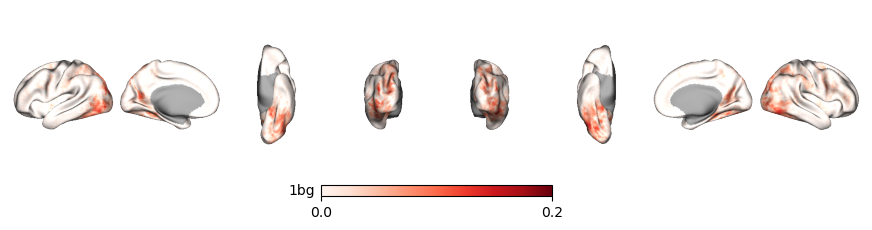

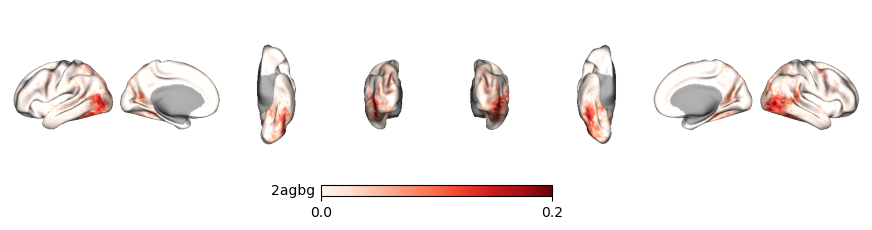

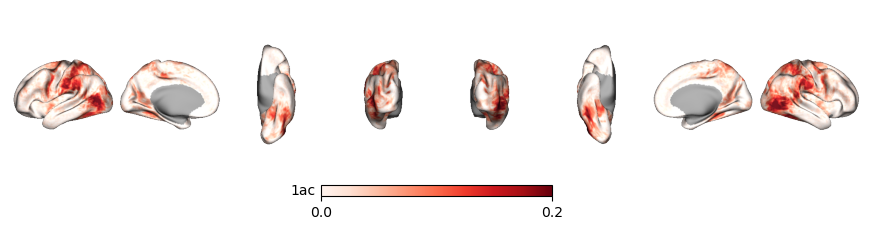

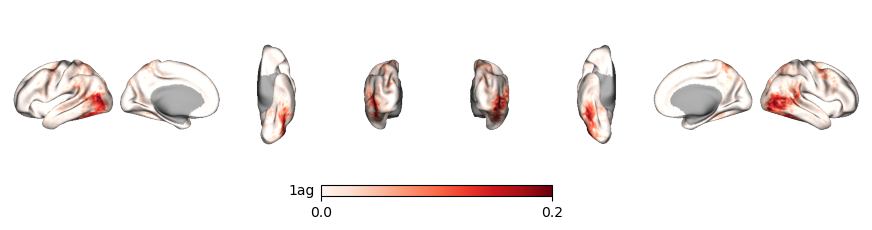

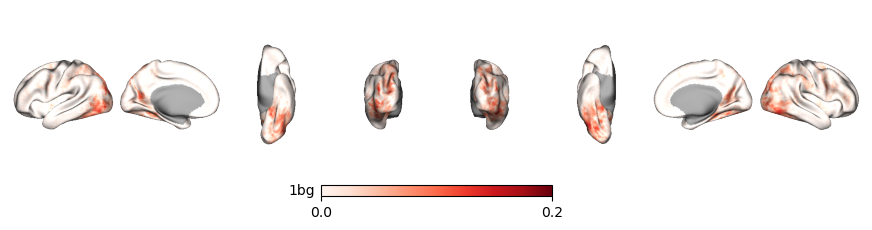

In [117]:
fsaverage_to_fslr_and_plot(f2_agbg_L_fname, f2_agbg_R_fname, f'2agbg', cmap = 'Reds', min=0, max=.2)
fsaverage_to_fslr_and_plot(f1_ac_L_fname, f1_ac_R_fname, f'1ac', cmap = 'Reds', min=0, max=.2)
fsaverage_to_fslr_and_plot(f1_ag_L_fname, f1_ag_R_fname, f'1ag', cmap = 'Reds', min=0, max=.2)
fsaverage_to_fslr_and_plot(f1_bg_L_fname, f1_bg_R_fname, f'1bg', cmap = 'Reds', min=0, max=.2)
fsaverage_to_fslr_and_plot(f1_mo_L_fname, f1_mo_R_fname, f'1mo', cmap = 'Reds', min=0, max=.2)

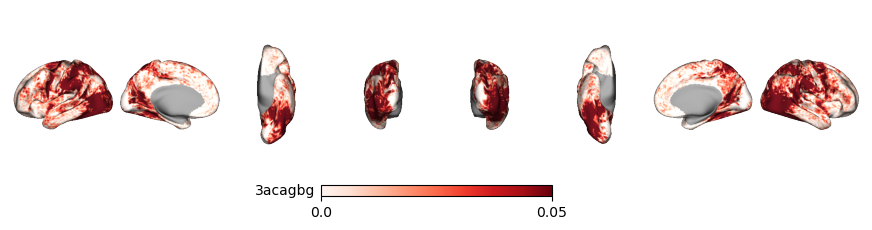

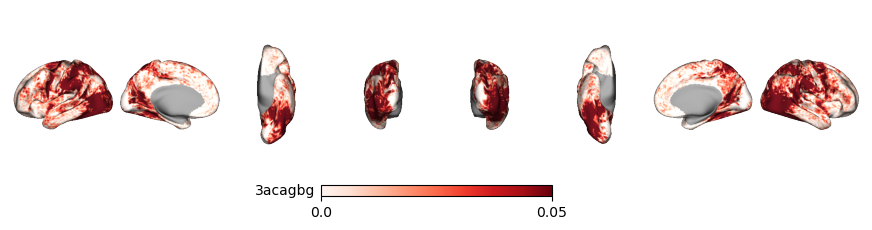

In [117]:
fsaverage_to_fslr_and_plot(f3_acagbg_L_fname, f3_acagbg_R_fname, f'3acagbg', cmap = 'Reds')

In [129]:
write_gifti_v2(f1_ac_L.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"lh.pial.gii"), 
        output_fn = join(save_dir, "TST_actions.lh.gii"))
write_gifti_v2(f1_ac_R.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"rh.pial.gii"), 
        output_fn = join(save_dir, "TST_actions.rh.gii"))
print(f"max value: {np.max(nib.load(join(save_dir, "TST_actions.lh.gii")).agg_data())}")
fsaverage_to_fslr_and_plot(join(save_dir, "TST_actions.lh.gii"), 
                           join(save_dir, "TST_actions.rh.gii"), f'unique_actions', cmap = 'YlOrRd')

In [130]:
np.max(nib.load(join(save_dir, "TST_actions.lh.gii")).agg_data())

0.12688039

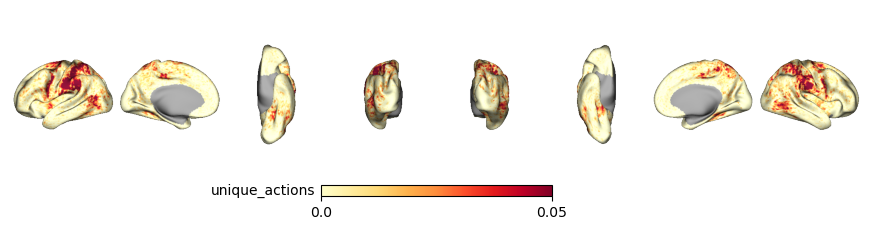

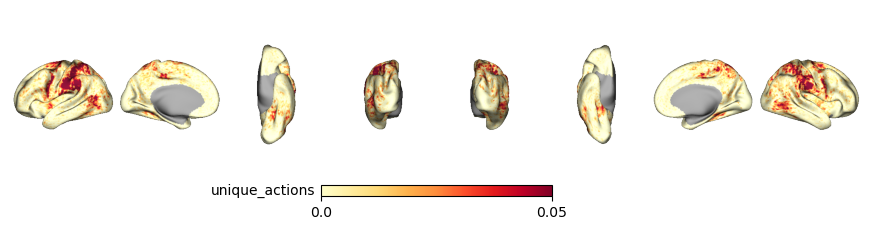

In [132]:
fsaverage_to_fslr_and_plot(join(save_dir, "TST_actions.lh.gii"), 
                           join(save_dir, "TST_actions.rh.gii"), f'unique_actions', cmap = 'YlOrRd')

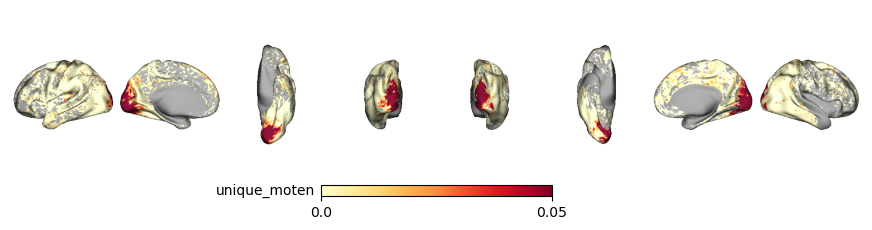

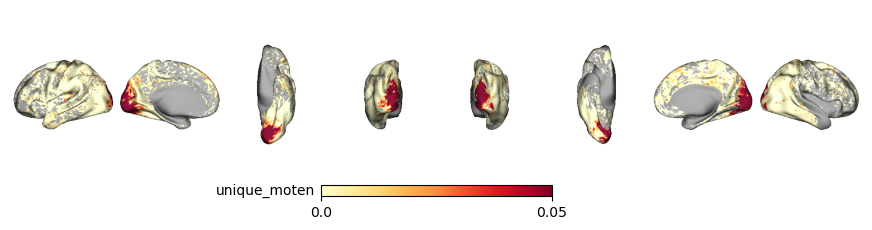

In [136]:
write_gifti_v2(f1_mo_L.astype(np.float32)*maskL,
        template_fn = os.path.join(suma_dir, f"lh.pial.gii"), 
        output_fn = join(save_dir, "TST_moten.lh.gii"))
write_gifti_v2(f1_mo_R.astype(np.float32)*maskR,
        template_fn = os.path.join(suma_dir, f"rh.pial.gii"), 
        output_fn = join(save_dir, "TST_moten.rh.gii"))
# print(f"max value: {np.max(nib.load(join(save_dir, "TST_moten.lh.gii")).agg_data()) }")
fsaverage_to_fslr_and_plot(join(save_dir, "TST_moten.lh.gii"), 
                           join(save_dir, "TST_moten.rh.gii"), f'unique_moten', cmap = 'YlOrRd')